In [1]:
from particle_propagation import Particle_Propagator,calulate_sigma_px,emmitance_propagation,single_particle
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm


Propagator=Particle_Propagator()

In [2]:
def plot_rounds_survived_without_kick(x_list,px_list,return_plot = True):
    """
    Plots for a grid the amount of rounds survived without kick.
    """
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
    
    result_list,x_processes,_,start_list = Propagator.run_1000(extended_x_list,extended_px_list,
                                                     rounds_to_save = np.arange(1000),  #save all rounds, to count later
                                        when_activate_NLK=0,kicker_strength=0.0)

    x_processes = [len(x[x!=0]) for x in x_processes]   #remove everywhere where x=0, as it means x not changed
    x_processes = np.array(x_processes)
    x_processes[x_processes>15]=15 

    print(f"In total: {sum(np.array(result_list))} out of {len(result_list)} electrons made it")
    
    new_list = []
    for i in range(len(result_list)):
        new_list.append((x_processes[i],start_list[i]))
    
    new_list.sort(key=lambda y: y[1][1])
    new_list.sort(key=lambda y: y[1][0])

    new_list = new_list[:]

    x=np.unique(extended_x_list)
    y=np.unique(px_list)
    X,Y = np.meshgrid(x,y)
    
    Z = np.array([[int(new_list[j][0]) for j in range(i*len(px_list),(i+1)*len(px_list))]
                                                                     for i in range(len(x_list))]).T
    
    # TEST -------------
    _,x_process,_,starts = single_particle(0.018,0.0010,
                                                     rounds_to_save = np.arange(1000),
                                        when_activate_NLK=0,kicker_strength=0.0)
    print("Value at x = 18mm, px=0.0010 is",len(x_process))
    _,x_process,_,starts = single_particle(0.018,0.0,
                                                     rounds_to_save = np.arange(1000),
                                        when_activate_NLK=0,kicker_strength=0.0)
    print("Value at x = 18mm, px=0.0 is",len(x_process))
    _,x_process,_,starts = single_particle(0.018,-0.0010,
                                                     rounds_to_save = np.arange(1000),
                                        when_activate_NLK=0,kicker_strength=0.0)
    print("Value at x = 18mm, px=-0.0010 is",len(x_process))
    _,x_process,_,starts = single_particle(0.016,-0.00075,
                                                     rounds_to_save = np.arange(1000),
                                        when_activate_NLK=0,kicker_strength=0.0)
    print("Value at x = 16mm, px=-0.00075 is",len(x_process))
    _,x_process,_,starts = single_particle(0.0155,-0.0005,
                                                     rounds_to_save = np.arange(1000),
                                        when_activate_NLK=0,kicker_strength=0.0)
    print("Value at x = 15.5mm, px=-0.0005 is",len(x_process))
    _,x_process,_,starts = single_particle(0.0151,-0.0003,
                                                     rounds_to_save = np.arange(1000),
                                        when_activate_NLK=0,kicker_strength=0.0)
    print("Value at x = 15.1mm, px=-0.0003 is",len(x_process))
    #-------------------
    
    if return_plot == False:
        return X,Y,Z
    
    plt.figure(figsize=(9,5))

    plt.pcolormesh(X*1000,Y*1000,Z)
    
    plt.colorbar()

    x = np.linspace(15.01e-3,22.85e-3,360)
    poly = PolynomialFeatures(degree=4)
    x_poly = poly.fit_transform(x[:,None])

    plt.plot(x*1000,(x_poly@nlk_sampler.lower)*1000,c="orange",label="injection area")
    plt.plot(x*1000,(x_poly@nlk_sampler.upper)*1000,c="orange")

    plt.legend(loc = "lower right")
    
    
    
    plt.title(f"Number of rounds electrons survive without kicker")
    plt.ylabel("px in mrad")
    plt.xlabel("x in mm")
    plt.show()

In [3]:
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class NLK_Sampler:
    #this class is used to sample new electrons
    def __init__(self):
        self.lower = np.array([0.01242802014328473,-2.3510967845422677,    #lower polynom weights, for injection area
                                 135.64889234592374,-2621.6674111929387,8374.6738385004])   
        self.upper = np.array([-0.026705410090359233,6.412451482988342,  #upper polynom weights, for injection area
                                 -549.8383734808201,20891.368558370945,-298723.030031348])
        self.diff = self.upper-self.lower
        self.transform = np.array([-3.2911361375977704,102.00328087158005,
                                   15593.102791660853,-518062.7698926044])
        self.poly = PolynomialFeatures(degree=4)
        self.poly_transform = PolynomialFeatures(degree=3)
    
    def sample(self):
        x = np.random.uniform(size=(1,1))
        x = x**1.8       #fixing term, not known why to use
        x = x*(22.85e-3-15e-3)+15e-3

        x_poly = self.poly_transform.fit_transform(x)
        x = x_poly@self.transform
        x = x*(22.85e-3-15e-3)+15e-3

        x = np.array([[x[0]]])
        

        height = np.random.uniform()
        x_poly = self.poly.fit_transform(x)   #to x^0,x^1,...,x^4
        y = x_poly@self.lower + height*x_poly@self.diff
        return x[0,0],y[0]
    
nlk_sampler = NLK_Sampler()

Needed time: 15.1322500705719
In total: 0.0 out of 16200 electrons made it
Value at x = 18mm, px=0.0010 is 5
Value at x = 18mm, px=0.0 is 6
Value at x = 18mm, px=-0.0010 is 1
Value at x = 16mm, px=-0.00075 is 7
Value at x = 15.5mm, px=-0.0005 is 13
Value at x = 15.1mm, px=-0.0003 is 19


<ipython-input-2-2659ff8f83c0>:66: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X*1000,Y*1000,Z)


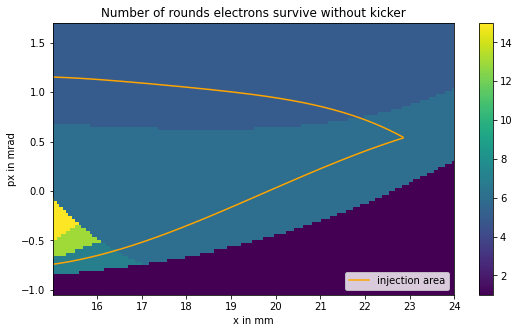

In [4]:
plot_rounds_survived_without_kick(np.linspace(15.001e-3,24e-3,180),np.linspace(-10.5e-4,17e-4,90)) 